### 1. EDA (exploratory data analysis)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import statsmodels.api as sm
import scipy.stats as stats
import re


from scipy.stats import chi2_contingency
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support, auc, classification_report, fbeta_score, make_scorer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import CountVectorizer


from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

import kagglehub
import tqdm as notebook_tqdm


In [21]:
# Data Analyst Jobs dataset
path = kagglehub.dataset_download("andrewmvd/data-analyst-jobs")
print("Path to dataset files:", path)
df = pd.read_csv(path + '\DataAnalyst.csv')

print('Dimensions inicials:', df.shape)

Path to dataset files: C:\Users\beert\.cache\kagglehub\datasets\andrewmvd\data-analyst-jobs\versions\1
Dimensions inicials: (2253, 16)


In [22]:
df.describe()

,Unnamed: 0,Rating,Founded
count,2253.0000,2253.000000,2253.000000
mean,1126.0000,3.160630,1398.522858
std,650.5294,1.665228,901.929251
min,0.0000,-1.000000,-1.000000
25%,563.0000,3.100000,-1.000000
50%,1126.0000,3.600000,1979.000000
75%,1689.0000,4.000000,2002.000000
max,2252.0000,5.000000,2019.000000


In [23]:
numeric_features = df.select_dtypes(np.number).keys()
print("Atributs numèrics: ", numeric_features)
non_numeric = [k for k in df.keys() if k not in numeric_features]
print("Atributs no numèrics: ", non_numeric)

Atributs numèrics:  Index(['Unnamed: 0', 'Rating', 'Founded'], dtype='object')
Atributs no numèrics:  ['Job Title', 'Salary Estimate', 'Job Description', 'Company Name', 'Location', 'Headquarters', 'Size', 'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors', 'Easy Apply']


In [24]:
unique_values = df['Salary Estimate'].unique()
print(unique_values)

['$37K-$66K (Glassdoor est.)' '$46K-$87K (Glassdoor est.)'
 '$51K-$88K (Glassdoor est.)' '$51K-$87K (Glassdoor est.)'
 '$59K-$85K (Glassdoor est.)' '$43K-$76K (Glassdoor est.)'
 '$60K-$110K (Glassdoor est.)' '$41K-$78K (Glassdoor est.)'
 '$45K-$88K (Glassdoor est.)' '$73K-$127K (Glassdoor est.)'
 '$84K-$90K (Glassdoor est.)' '$27K-$52K (Glassdoor est.)'
 '$42K-$74K (Glassdoor est.)' '$77K-$132K (Glassdoor est.)'
 '$98K-$114K (Glassdoor est.)' '$48K-$96K (Glassdoor est.)'
 '$26K-$47K (Glassdoor est.)' '$31K-$59K (Glassdoor est.)'
 '$47K-$81K (Glassdoor est.)' '$43K-$69K (Glassdoor est.)'
 '$49K-$112K (Glassdoor est.)' '$30K-$54K (Glassdoor est.)'
 '$55K-$103K (Glassdoor est.)' '$37K-$70K (Glassdoor est.)'
 '$57K-$103K (Glassdoor est.)' '$35K-$45K (Glassdoor est.)'
 '$42K-$66K (Glassdoor est.)' '$65K-$81K (Glassdoor est.)'
 '$113K-$132K (Glassdoor est.)' '$42K-$63K (Glassdoor est.)'
 '$60K-$66K (Glassdoor est.)' '$73K-$82K (Glassdoor est.)'
 '$67K-$92K (Glassdoor est.)' '$42K-$76K (Glass

Salary Estimate és la variable target de l'estudi. Ara mateix te valors string que desciuen un interval, el tranformarem en valors numerics. L'objectiu serà predir el sou que oferex un lloc de treball qualsevol.

**Distribució de les variables de la base de dades**

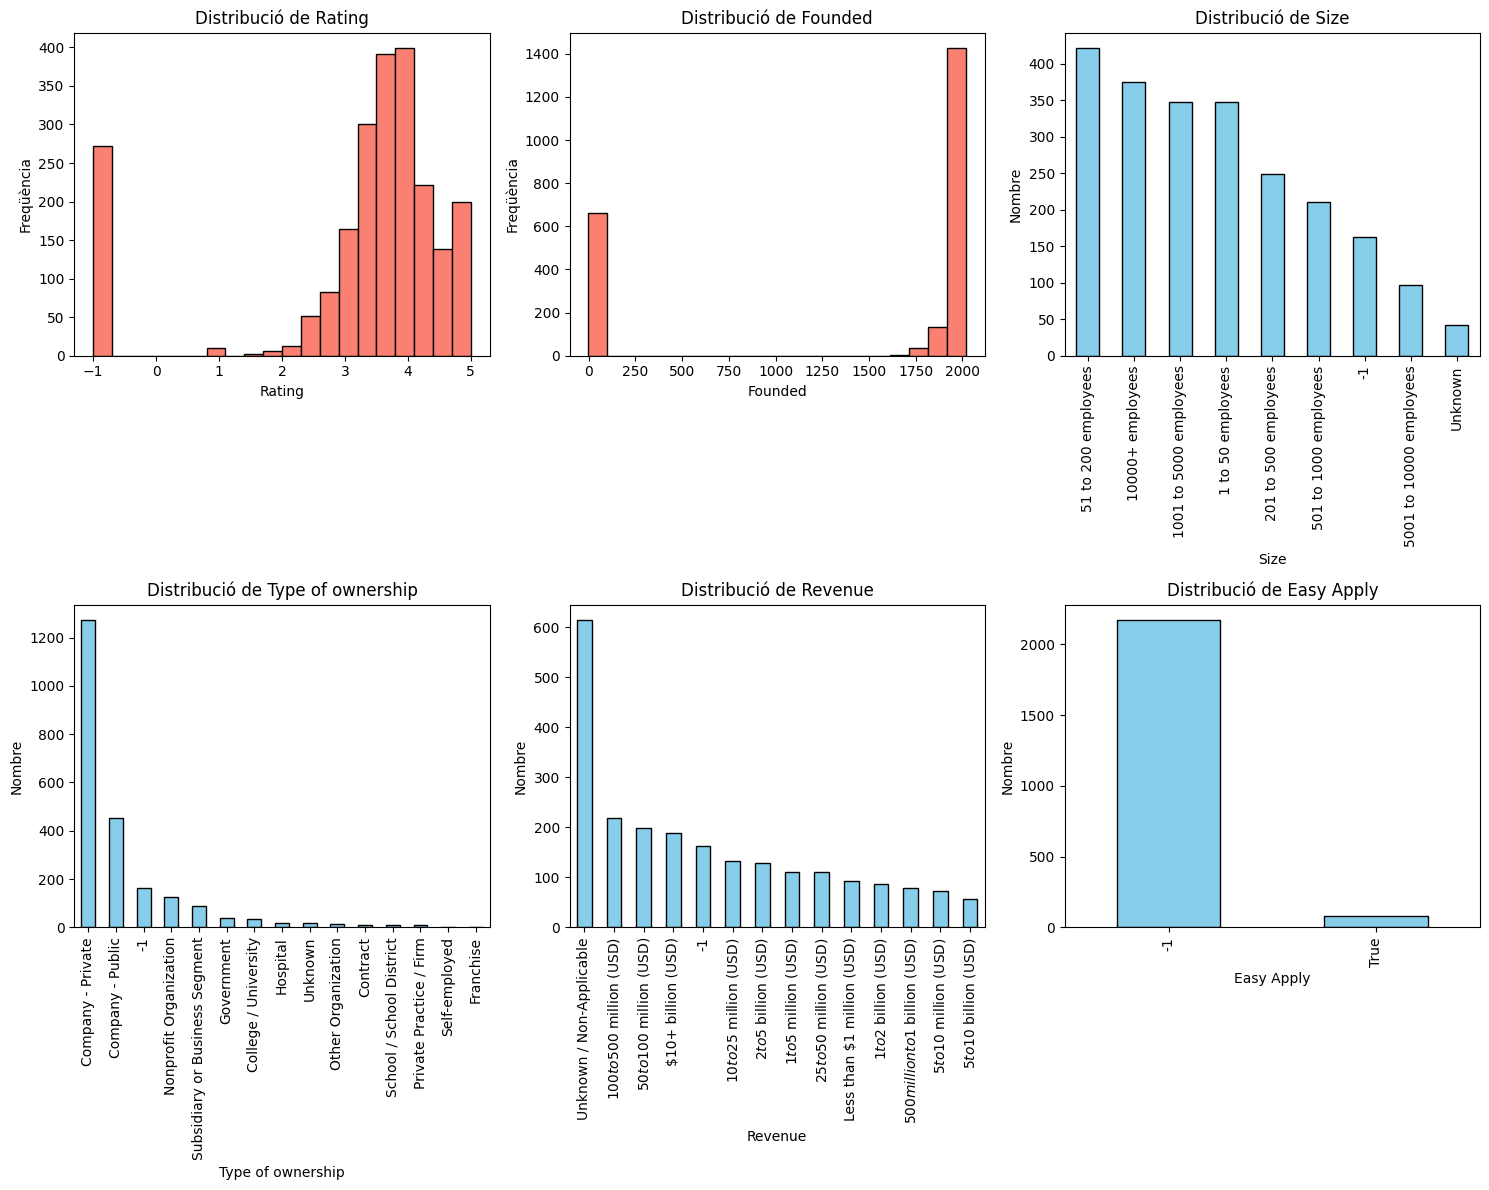

In [25]:
# Variables numèriques o categòriques que no tenen massa valors únics ("name" no s'afageix perquè té massa valors únics)
cols = ["Rating", "Founded", "Size", "Type of ownership", "Revenue", "Easy Apply"] 

ncols = 3
nrows = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(cols):
    ax = axes[i]
    if df[col].dtype == "object" or df[col].nunique() < 10:  
        # Categórica o discreta → barras
       
        df[col].value_counts().plot(kind="bar", ax=ax, color="skyblue", edgecolor="black")
        ax.set_title(f"Distribució de {col}")
        ax.set_ylabel("Nombre")
    else:
        # Numérica continua → histograma
        df[col].plot(kind="hist", ax=ax, bins=20, color="salmon", edgecolor="black")
        ax.set_title(f"Distribució de {col}")
        ax.set_ylabel("Freqüència")

    ax.set_xlabel(col)

# Eliminar subplots vacíos si hay
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

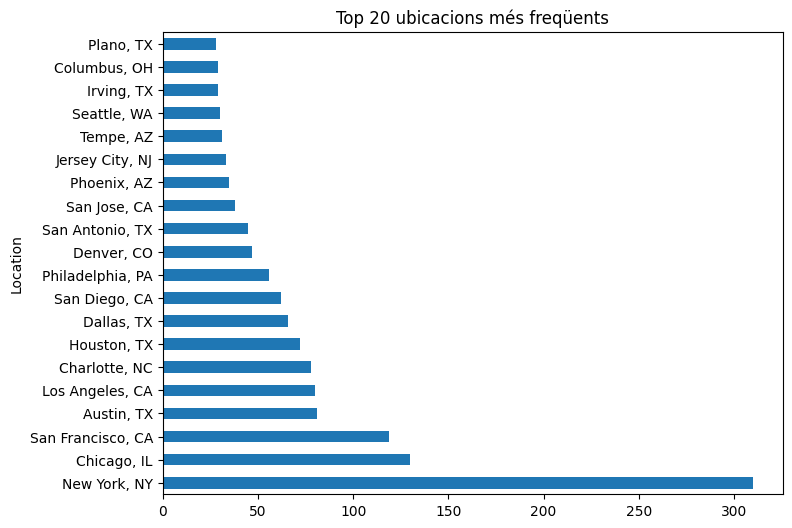

In [26]:
# ubicacions mes frequents
df['Location'].value_counts().head(20).plot(kind='barh', figsize=(8,6))
plt.title("Top 20 ubicacions més freqüents")
plt.show()

In [27]:
# mirem si hi ha duplicats en localitats basat en la similitud del text
from difflib import SequenceMatcher

locations = sorted(df['Location'].unique())

similar_pairs = []

for i in range(len(locations)):
    for j in range(i+1, len(locations)):
        ratio = SequenceMatcher(None, locations[i], locations[j]).ratio()
        if ratio > 0.85 and ratio < 1:  # similars però no iguals
            similar_pairs.append((locations[i], locations[j], ratio))

for a, b, r in similar_pairs:
    print(f"{a}  <-->  {b}   (sim={r:.2f})")

Burlingame, CA  <-->  Burlingame, KS   (sim=0.86)
Conshohocken, PA  <-->  West Conshohocken, PA   (sim=0.86)
Glendale, AZ  <-->  Glendale, CA   (sim=0.92)
Hanford, CA  <-->  Stanford, CA   (sim=0.87)


Tot i les coincidències en el nom o estat no es presenten errors tipogràfics ni d'estat, totes les ciutats esmentades existeixen en els seus respectius estats, per tant, res a tractar. En cas d'ampliar la ratio a un minim de 0.70 segueixen sent totes les ciutats llistades correctes per tant confirmem que no hi ha res a tractar. 

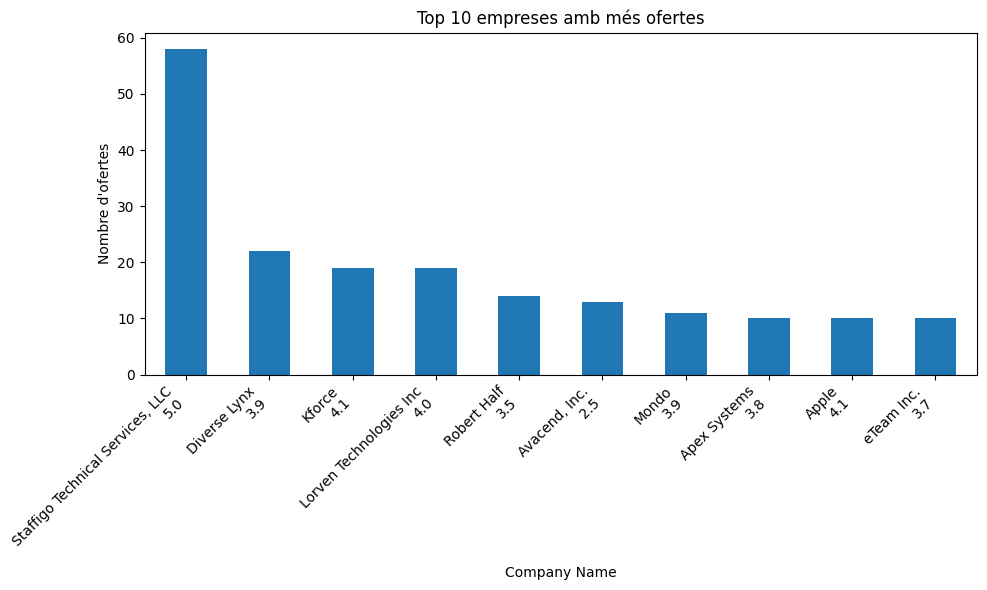

In [28]:
# Comptar ofertes per empresa
top_companies = df['Company Name'].value_counts().head(10)

plt.figure(figsize=(10, 6))
top_companies.plot(kind='bar')
plt.title("Top 10 empreses amb més ofertes")
plt.xlabel("Company Name")
plt.ylabel("Nombre d'ofertes")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

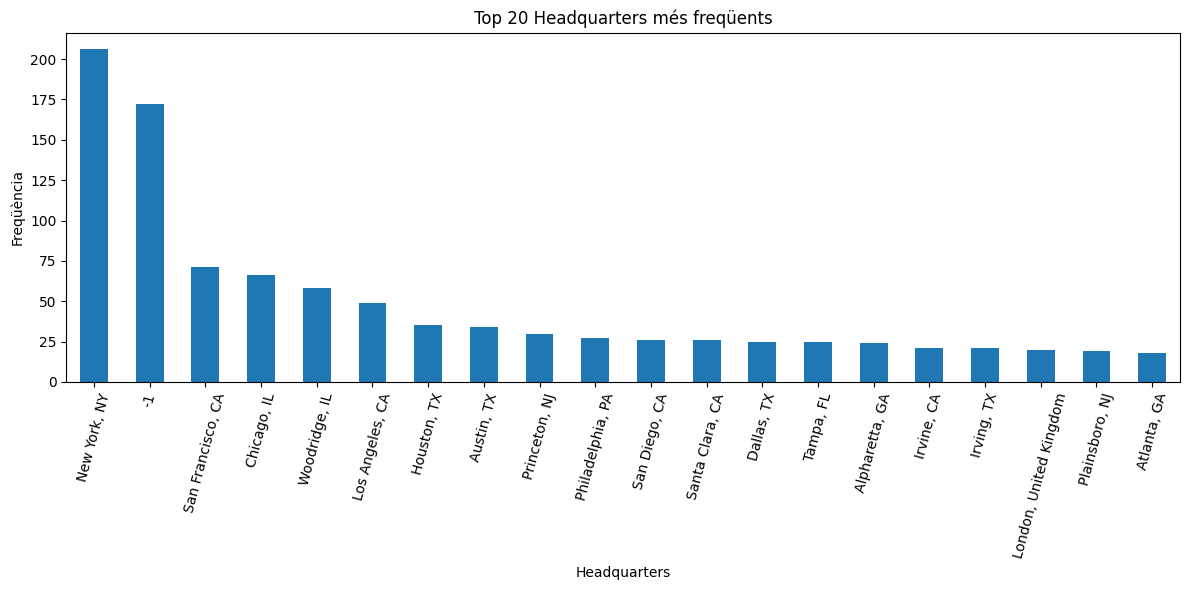

In [29]:
plt.figure(figsize=(12,6))
df['Headquarters'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 Headquarters més freqüents')
plt.xlabel('Headquarters')
plt.ylabel('Freqüència')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

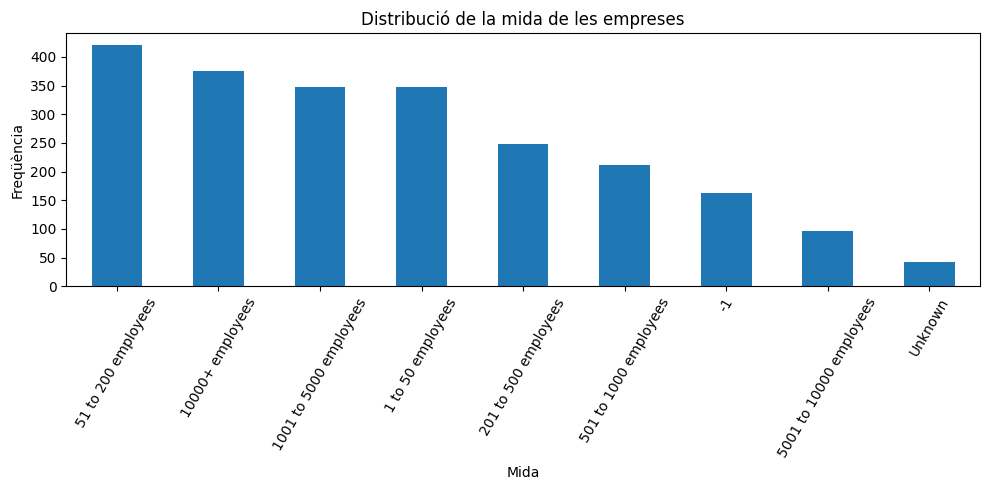

In [30]:
plt.figure(figsize=(10,5))
df['Size'].value_counts().plot(kind='bar')
plt.title('Distribució de la mida de les empreses')
plt.xlabel('Mida')
plt.ylabel('Freqüència')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

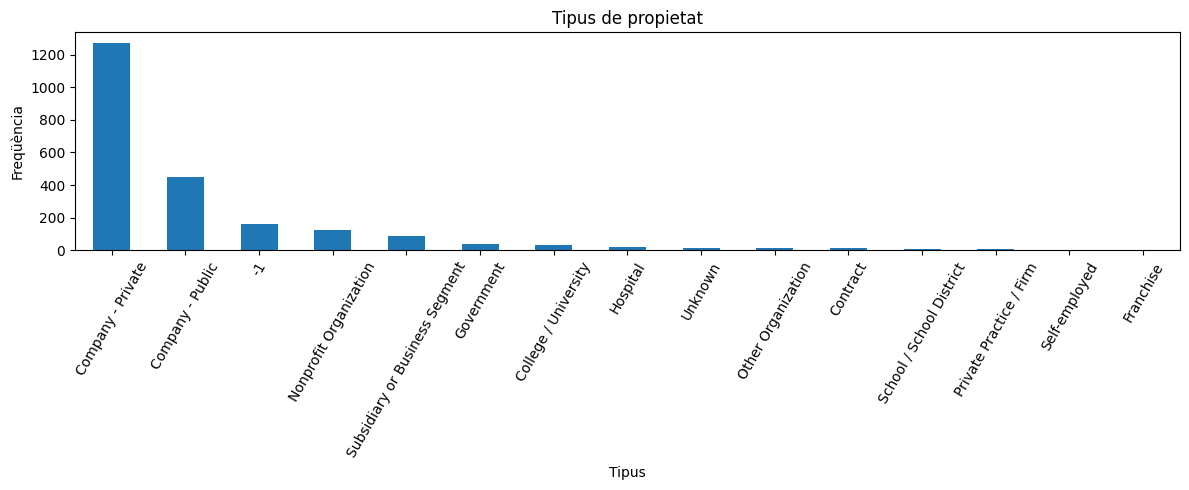

In [31]:
plt.figure(figsize=(12,5))
df['Type of ownership'].value_counts().plot(kind='bar')
plt.title('Tipus de propietat')
plt.xlabel('Tipus')
plt.ylabel('Freqüència')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

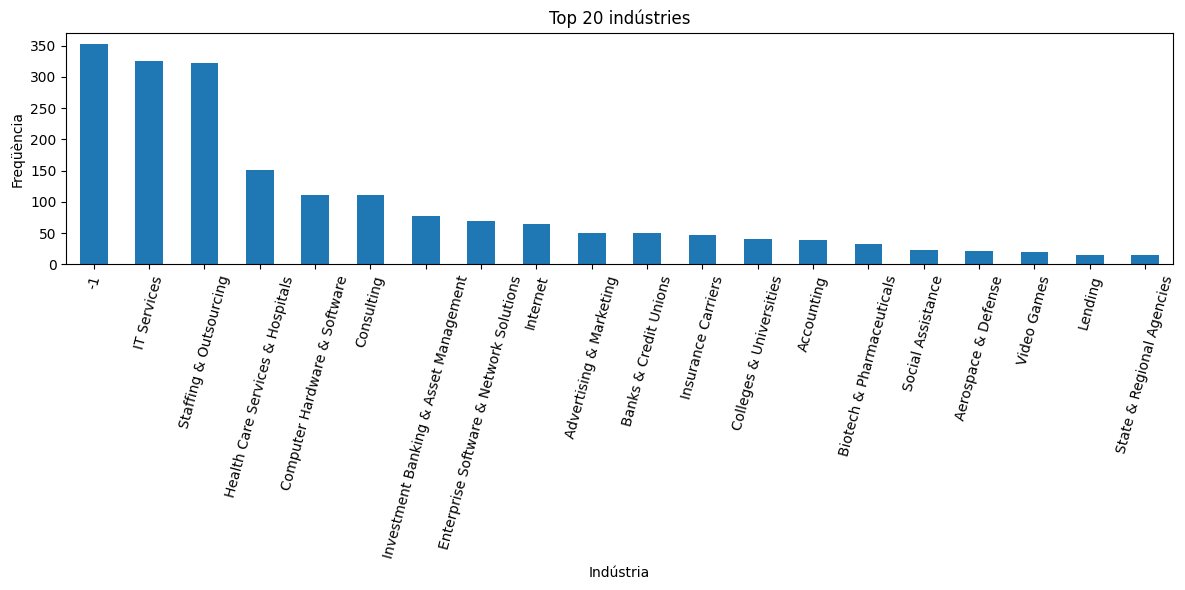

In [32]:
plt.figure(figsize=(12,6))
df['Industry'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 indústries')
plt.xlabel('Indústria')
plt.ylabel('Freqüència')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()


**Visualització dades categòriques per freqüència de paraules**

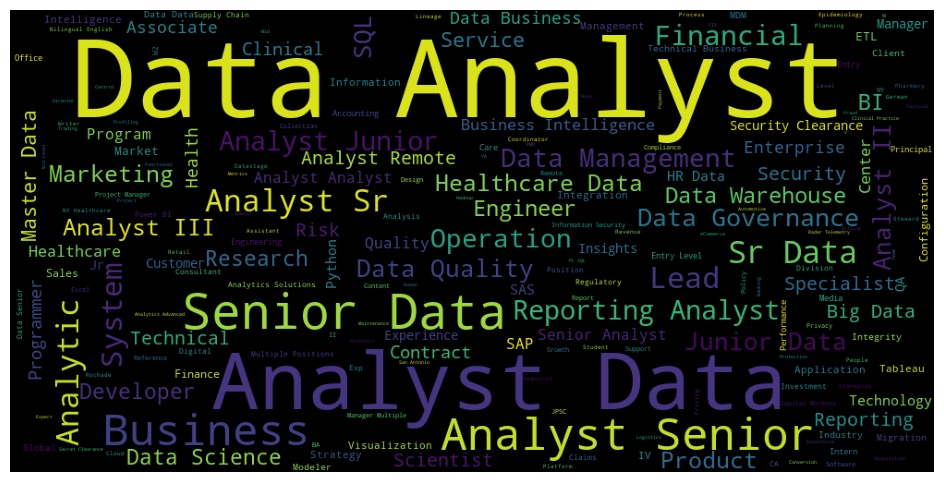

In [33]:
text = " ".join(df['Job Title'].astype(str))
wc = WordCloud(width=1000, height=500).generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wc)
plt.axis("off")
plt.show()

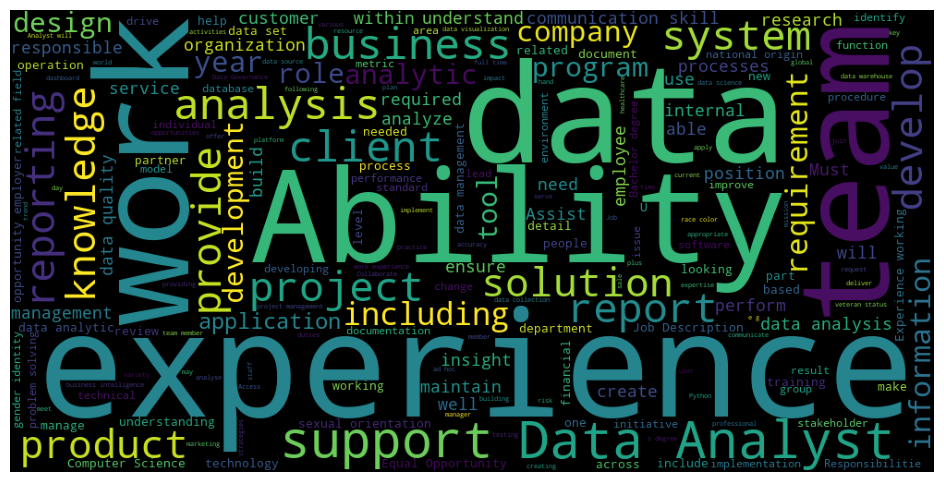

In [34]:
text = " ".join(df['Job Description'].astype(str))
wc = WordCloud(width=1000, height=500).generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wc)
plt.axis("off")
plt.show()

**Nuls del Dataset**

In [35]:
missing = df.isna().sum() # Valors nuls normals

special_missing = (df == -1).sum() # Valors amb -1 considerats com a nuls
special_missing += (df == "-1").sum()
special_missing += (df == -1.0).sum()

total_missing = missing.add(special_missing, fill_value=0)
#total_missing = total_missing[total_missing > 0]

print("Valors nuls per columna (incloent -1 com a nuls):")
total_missing

Valors nuls per columna (incloent -1 com a nuls):


Unnamed: 0              0
Job Title               0
Salary Estimate         1
Job Description         0
Rating                544
Company Name            1
Location                0
Headquarters          172
Size                  163
Founded              1320
Type of ownership     163
Industry              353
Sector                353
Revenue               163
Competitors          1732
Easy Apply           2173
dtype: int64

**Correlacions:**

No podem afegir correlacions entre qualsevol variable i el target perque el target n o és numèric encara (caldrà transformar-lo). De moment mirem les correlacions entre els atributs entre ells.

In [36]:
# Separar variables numèriques i categòriques
numeric_df = df.select_dtypes(include=["number"])
categorical_df = df.select_dtypes(include=["object"])

# Numèrica
corr_num = numeric_df.corr().round(3)
display(corr_num)

# Categòrica amb Cramer's V
def cramers_v(x, y):
    table = pd.crosstab(x, y)
    chi2 = chi2_contingency(table)[0]
    n = table.sum().sum()
    phi2 = chi2 / n
    r, k = table.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

corr_cat = pd.DataFrame(
    {
        col1: [
            cramers_v(categorical_df[col1], categorical_df[col2])
            for col2 in categorical_df.columns
        ]
        for col1 in categorical_df.columns
    },
    index=categorical_df.columns
).round(3)

display(corr_cat)

,Unnamed: 0,Rating,Founded
Unnamed: 0,1.000,0.044,0.052
Rating,0.044,1.000,0.500
Founded,0.052,0.500,1.000


,Job Title,Salary Estimate,Job Description,Company Name,Location,Headquarters,Size,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
Job Title,1.000,0.790,1.0,0.823,0.789,0.762,0.766,0.747,0.775,0.741,0.771,0.755,0.740
Salary Estimate,0.790,1.000,1.0,0.833,0.585,0.517,0.210,0.232,0.214,0.222,0.223,0.353,0.229
Job Description,1.000,1.000,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
Company Name,0.823,0.833,1.0,1.000,0.911,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0.997
Location,0.789,0.585,1.0,0.911,1.000,0.674,0.368,0.476,0.447,0.446,0.383,0.409,0.273
Headquarters,0.762,0.517,1.0,1.000,0.674,1.000,0.700,0.717,0.635,0.674,0.707,0.566,0.572
Size,0.766,0.210,1.0,1.000,0.368,0.700,1.000,0.448,0.386,0.327,0.546,0.461,0.149
Type of ownership,0.747,0.232,1.0,1.000,0.476,0.717,0.448,1.000,0.523,0.423,0.350,0.385,0.163
Industry,0.775,0.214,1.0,1.000,0.447,0.635,0.386,0.523,1.000,1.000,0.377,0.561,0.271
Sector,0.741,0.222,1.0,1.000,0.446,0.674,0.327,0.423,1.000,1.000,0.286,0.500,0.167


En una primera anàlisi, observem que les variables que presenten una correlació més alta amb la variable objectiu “Salary Estimate” són Job Title, Job Description, Company Name, Location i Headquarters.

Aquestes relacions resulten coherents. La descripció del lloc de treball és específica de cada oferta i, per tant, està directament vinculada al salari. Igualment, tant l’empresa com la ubicació (ciutat i seu) poden influir significativament en el nivell salarial: hi ha empreses que ofereixen sous més alts que d’altres i ciutats amb un cost de vida més elevat, fet que sovint es reflecteix en el sou ofert.